In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

from Cho2017 import SubjectData


plt.rcParams['figure.figsize'] = [12, 8]

# # Make sure ipympl is installed (via pip) for interactive plots in Jupyter 
# %matplotlib widget

In [2]:
subject = SubjectData('Cho2017-Data/s01.mat')

In [3]:
tmin = -0.5     # As selected by Cho 2017 (Reliability Section: Methods), the cue occurs @ t=0
tmax = 2.5     # and the visual stimulus is observed for 3s (Figure 2)
reject_criteria = {'eeg': 100e-6}     # Rejection criteria used by Cho 2017
filter_freqs = (8, 30)
filter_props = dict(picks=['eeg'], fir_design='firwin', skip_by_annotation='edge')

# ['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6']
picks = mne.pick_channels(subject.raw_imagery_left.info["ch_names"], ['C3', 'Cz', 'C4']) #Original ex: C3, Cz, C4 only

im_left_epochs = subject.get_epochs('imagery_left', picks=picks)
im_right_epochs = subject.get_epochs('imagery_right', picks=picks)

100 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 100 events and 3585 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (1.650 sec)

    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'Cz']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'Cz']
    Rejecting  epoch based on EEG : ['C4']


In [4]:
# picks = ['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6']
# im_left_epochs.plot(title='Im Left', picks=picks, n_epochs=1)
# im_right_epochs.plot(title='Im Right', picks=picks, n_epochs=1)
# im_left_epochs.plot_psd(picks=picks, fmax=50)
# im_right_epochs.plot_psd(picks=picks, fmax=50)
# im_left_epochs.plot_image(picks='C6')
# im_left_epochs.plot_image(picks='C5')

In [5]:
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.preprocessing import ICA

freqs = np.arange(8, 30, 0.1)  # frequencies from 2-35Hz
n_cycles = freqs             # use constant t/f resolution
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

# Run Time-Frequency decomposition overall epochs
tfr_left = tfr_morlet(im_left_epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=False, return_itc=False, average=True)
tfr_right = tfr_morlet(im_right_epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=False, return_itc=False, average=True)
tfr_left.apply_baseline([-0.5, 0], mode='percent')
tfr_right.apply_baseline([-0.5, 0], mode='percent')

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


<AverageTFR | time : [-2.000000, 5.000000], freq : [8.000000, 29.900000], nave : 94, channels : 3, ~18.1 MB>

In [6]:
print(im_left_epochs.get_data().shape)
print(tfr_left.data.shape)     # nCh, nFreq, nTime

(93, 3, 3585)
(3, 220, 3585)


No baseline correction applied
No baseline correction applied
No baseline correction applied


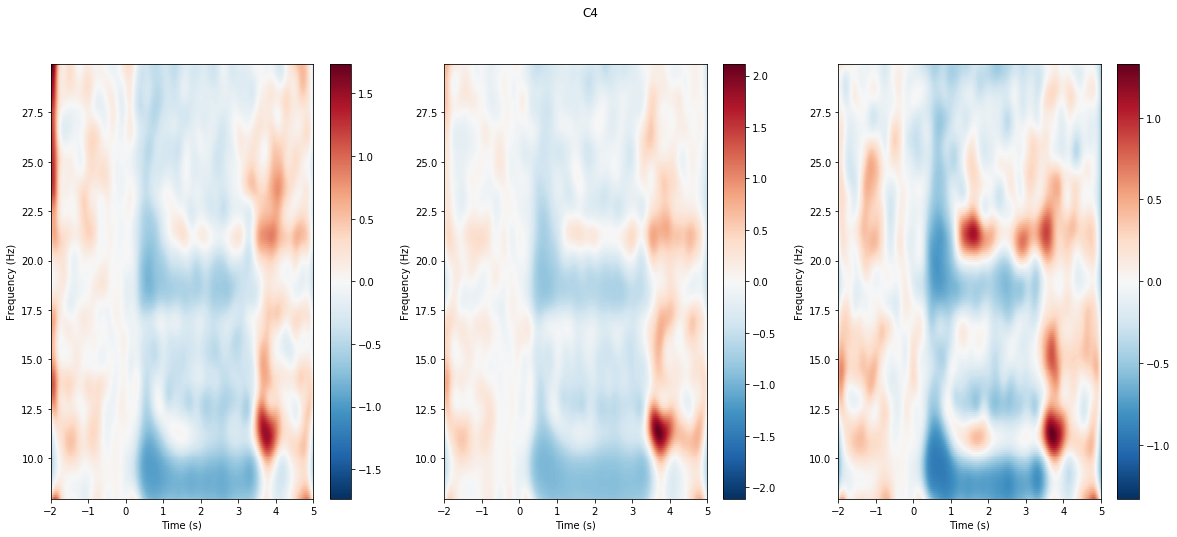

No baseline correction applied
No baseline correction applied
No baseline correction applied


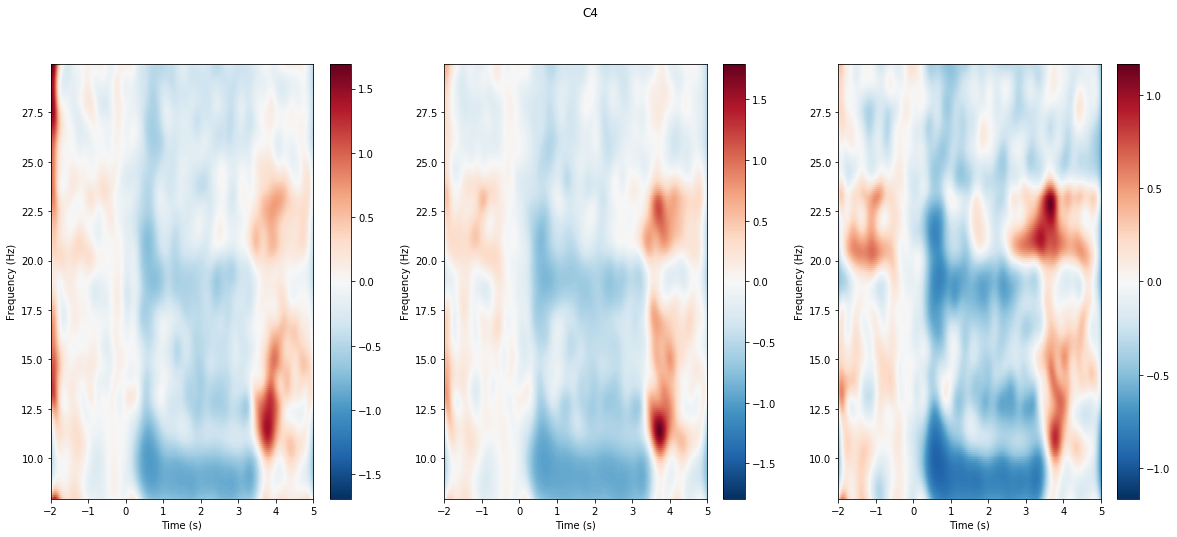

In [7]:
vmin = None
vmax = None

plt.rcParams['figure.figsize'] = [20, 8]

fig, axes = plt.subplots(1, 3)
for i, ax in enumerate(axes):
    tfr_left.plot([i], axes=ax, vmin=vmin, vmax=vmax, show=False);
plt.show()
    
fig, axes = plt.subplots(1, 3)
for i, ax in enumerate(axes):
    tfr_right.plot([i], axes=ax, vmin=vmin, vmax=vmax, show=False);
plt.show();

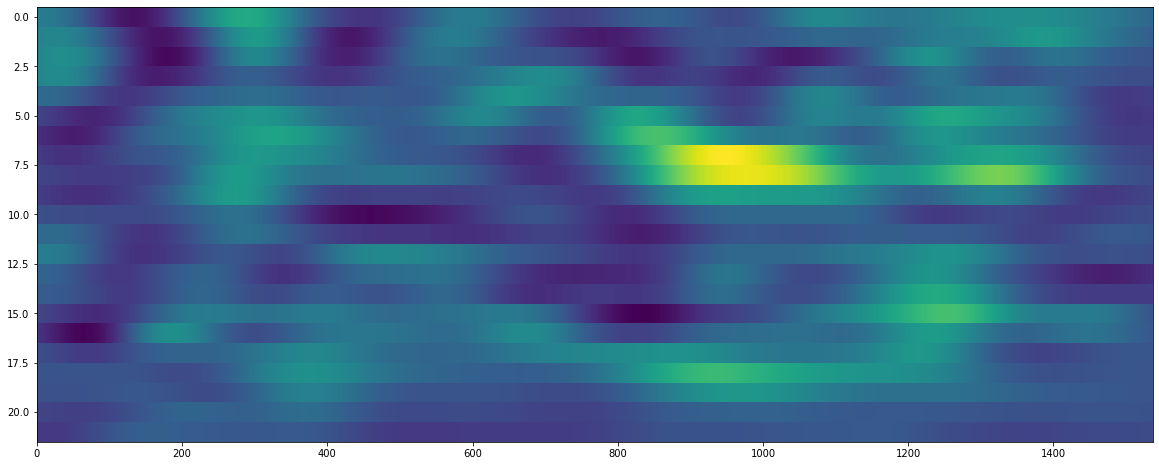

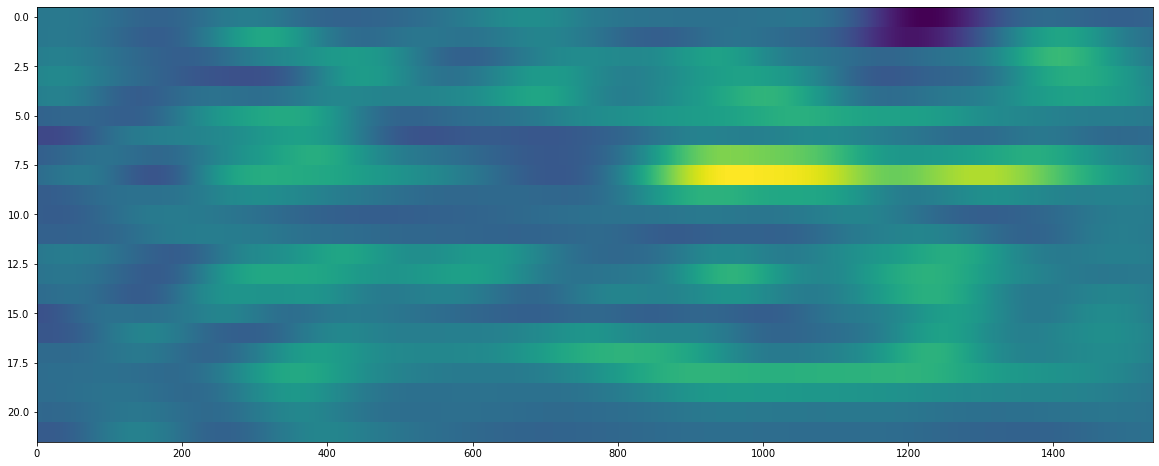

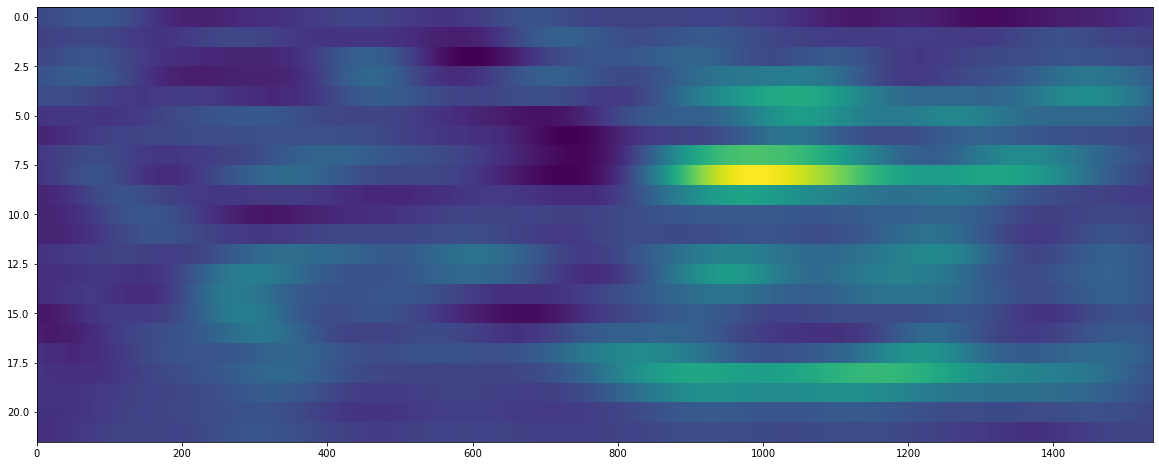

In [22]:
erds = tfr_left.data - tfr_right.data
erds.shape
for i in range(3):
    plt.imshow(erds[i][::-1, :], interpolation='nearest', aspect='auto')
    plt.show()

In [17]:
# positive clusters
_, c1, p1, _ = pcluster_test(tfr_left.data[:, ch, ...], tail=1, **kwargs)
# negative clusters
_, c2, p2, _ = pcluster_test(tfr_right.data[:, ch, ...], tail=-1,
                             **kwargs)
# note that we keep clusters with p <= 0.05 from the combined clusters
# of two independent tests; in this example, we do not correct for
# these two comparisons
c = np.stack(c1 + c2, axis=2)  # combined clusters
p = np.concatenate((p1, p2))  # combined p-values
mask = c[..., p <= 0.05].any(axis=-1)

Using a threshold of 1.669402
stat_fun(H1): min=8.245361 max=16.492901
Running initial clustering
Found 1 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.669402
stat_fun(H1): min=8.022412 max=16.962547
Running initial clustering
Found 0 clusters


<ipython-input-17-544a2515d55d>:5: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  **kwargs)


AxisError: axis 2 is out of bounds for array of dimension 2